In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

PARAMS = {'m': 1.0, 'g': 9.81,'Ix': 0.0081, 'Iy': 0.0081, 'Iz': 0.0142,}

def drone_dyn(t, state, con_in):
    x, y, z, phi, the, psi, dx, dy, dz, p, q, r = state
    T, tau_phi, tau_the, tau_psi = con_in

    # Safety
    phi = np.clip(phi, -1.3, 1.3)
    the = np.clip(the, -1.3, 1.3)

    c_phi = math.cos(phi); s_phi = math.sin(phi)
    c_the = math.cos(the); s_the = math.sin(the)
    c_psi = math.cos(psi); s_psi = math.sin(psi)
    t_the = math.tan(the)

    # Newton-Euler Equations
    R13 = s_phi*s_psi + c_phi*c_psi*s_the
    R23 = c_phi*s_psi*s_the - c_psi*s_phi
    R33 = c_phi*c_the

    ddx = (T/PARAMS['m']) * R13
    ddy = (T/PARAMS['m']) * R23
    ddz = (T/PARAMS['m']) * R33 - PARAMS['g']

    dp = (tau_phi + (PARAMS['Iy'] - PARAMS['Iz']) * q * r) / PARAMS['Ix']
    dq = (tau_the + (PARAMS['Iz'] - PARAMS['Ix']) * p * r) / PARAMS['Iy']
    dr = (tau_psi + (PARAMS['Ix'] - PARAMS['Iy']) * p * q) / PARAMS['Iz']

    # Kinematics
    if abs(c_the) < 0.01: c_the = 0.01
    dphi   = p + q * s_phi * t_the + r * c_phi * t_the
    dthe =     q * c_phi           - r * s_phi
    dpsi   =    (q * s_phi           + r * c_phi) / c_the
    return np.array([dx, dy, dz, dphi, dthe, dpsi, ddx, ddy, ddz, dp, dq, dr])

class DroneController:
    def __init__(self):
        self.Kp_pos = 2.0; self.Kd_pos = 4.0
        self.Kp_z = 10.0; self.Kd_z = 5.0
        self.Kp_att = 10.0; self.Kd_att = 5.0
        self.Kp_yaw = 2.0; self.Kd_yaw = 1.0

    def get_control(self, t, state, target):
        x, y, z, phi, the, psi, dx, dy, dz, p, q, r = state
        x_d, y_d, z_d, psi_d = target

        # Altitude
        ez = z_d - z; edz = 0 - dz
        u_z = self.Kp_z * ez + self.Kd_z * edz + PARAMS['g']

        # Tilt
        c_phi = np.clip(math.cos(phi), 0.1, 1.0)
        c_the = np.clip(math.cos(the), 0.1, 1.0)
        tot_thr = PARAMS['m'] * u_z / (c_phi * c_the)

        # Position
        ex = x_d - x; edx = 0 - dx
        ey = y_d - y; edy = 0 - dy
        ax_des = self.Kp_pos * ex + self.Kd_pos * edx
        ay_des = self.Kp_pos * ey + self.Kd_pos * edy
        the_des = np.clip(ax_des / PARAMS['g'], -0.5, 0.5)
        phi_des = np.clip(-ay_des / PARAMS['g'], -0.5, 0.5)

        # Attitude
        tau_phi = self.Kp_att * (phi_des - phi) + self.Kd_att * (0 - p)
        tau_the = self.Kp_att * (the_des - the) + self.Kd_att * (0 - q)
        tau_psi = self.Kp_yaw * (psi_d - psi) + self.Kd_yaw * (0 - r)
        return tot_thr, tau_phi, tau_the, tau_psi

def rk4_step(t, dt, state, ctrl, max_norm=1e3):
    state = state.astype(np.float64)
    k1 = drone_dyn(t,             state,                 ctrl)
    k2 = drone_dyn(t + 0.5*dt,    state + 0.5*dt*k1,     ctrl)
    k3 = drone_dyn(t + 0.5*dt,    state + 0.5*dt*k2,     ctrl)
    k4 = drone_dyn(t + dt,        state + dt*k3,         ctrl)
    next_state = state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    next_state = np.nan_to_num(next_state, nan=0.0, posinf=max_norm, neginf=-max_norm)
    n = np.linalg.norm(next_state)
    if n > max_norm:
        next_state = next_state * (max_norm / n)
    return next_state


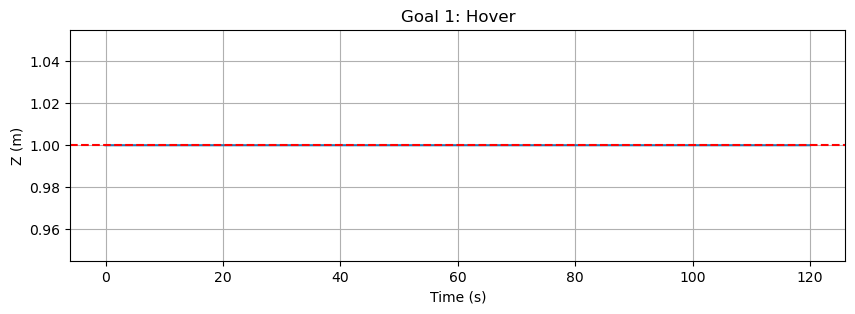

In [3]:
def run_goal1():
    dur = 120.0
    dt_sim = 0.01
    teval = np.arange(0.0, dur + dt_sim, dt_sim)
    steps = len(teval)
    states = np.zeros((steps, 12), dtype=float)
    states[0] = np.array([
        0.0, 0.0, 1.0, 
        0.0, 0.0, 0.0,  
        0.0, 0.0, 0.0,  
        0.0, 0.0, 0.0 ])
    cur_st = states[0].copy()
    control = DroneController()

    for i in range(steps - 1):
        t = teval[i]
        ctrl = control.get_control(t, cur_st, [0.0, 0.0, 1.0, 0.0])
        cur_st = rk4_step(t, dt_sim, cur_st, ctrl)
        states[i + 1] = cur_st
        
    return teval, states

t1, s1 = run_goal1()

plt.figure(figsize=(10, 3))
plt.plot(t1, s1[:, 2])
plt.axhline(1.0, color='r', linestyle='--')
plt.title('Goal 1: Hover'); plt.grid()
plt.xlabel('Time (s)'); plt.ylabel('Z (m)')
plt.show()

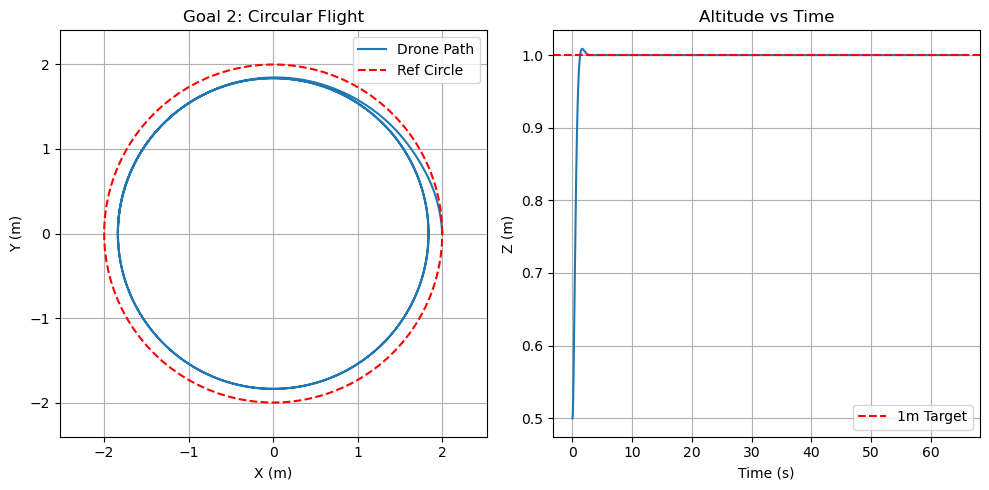

In [4]:
def run_goal_2():
    control = DroneController()

# Varibles
    dt = 0.002 
    dur = 65.0 
    this = np.arange(0.0, dur + dt, dt)
    steps = len(this)
    shis = np.zeros((steps, 12))
    cur_st = np.zeros(12)
    cur_st[0] = 2.0  
    cur_st[2] = 0.5  
    shis[0] = cur_st
    r = 2.0
    v = 0.5
    omega = v / r

    
    for i in range(steps - 1):
        t = this[i]

        the_circ = omega * t
        x_ref = r * math.cos(the_circ)
        y_ref = r * math.sin(the_circ)
        target = [x_ref, y_ref, 1.0, 0.0]

        ctrl = control.get_control(t, cur_st, target)
        cur_st = rk4_step(t, dt, cur_st, ctrl)
        shis[i+1] = cur_st

    return this, shis

t2, s2 = run_goal_2()

# Plot 1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(s2[:, 0], s2[:, 1], label='Drone Path')
ref_circle_x = 2.0 * np.cos(np.linspace(0, 2*np.pi, 100))
ref_circle_y = 2.0 * np.sin(np.linspace(0, 2*np.pi, 100))
plt.plot(ref_circle_x, ref_circle_y, 'r--', label='Ref Circle')
plt.title('Goal 2: Circular Flight')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.axis('equal'); plt.grid(); plt.legend()

# Plot 2
plt.subplot(1, 2, 2)
plt.plot(t2, s2[:, 2])
plt.axhline(1.0, color='r', linestyle='--', label='1m Target')
plt.title('Altitude vs Time')
plt.xlabel('Time (s)'); plt.ylabel('Z (m)')
plt.grid(); plt.legend()

plt.tight_layout()
plt.show()

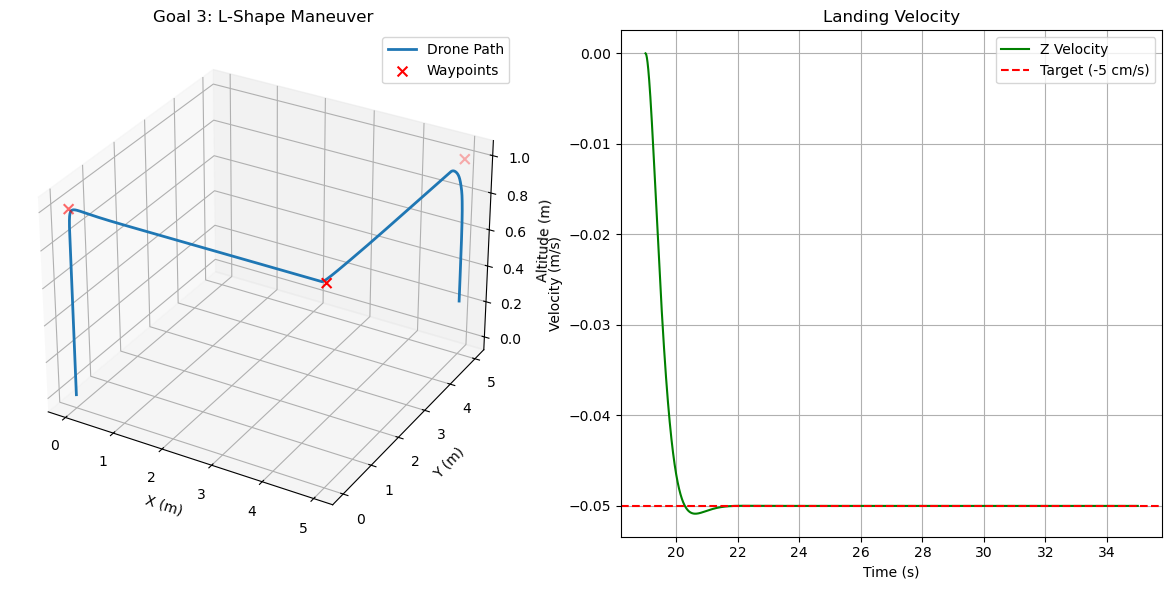

In [5]:
def run_goal_3():
    control = DroneController()

    def get_target(t):
        psi_fixed = 0.0 
        if t < 2.0:                                              # Start
            z = np.interp(t, [0, 2], [0, 1])
            return [0, 0, z, psi_fixed]
        elif t < 7.0:                                            # Move 1 
            x = np.interp(t, [2, 7], [0, 5])
            return [x, 0, 1, psi_fixed]
        elif t < 9.0:                                            # Hover
            return [5, 0, 1, psi_fixed]
        elif t < 12.0:                                           # Turn
            return [5, 0, 1, psi_fixed]
        elif t < 17.0:                                           # Move 2 
            y = np.interp(t, [12, 17], [0, 5])
            return [5, y, 1, psi_fixed]
        elif t < 19.0:                                           # Hover
            return [5, 5, 1, psi_fixed]
        else:                                                    # Land
            land = t - 19.0
            z = 1.0 - (land * 0.05)
            if z < 0: z = 0
            return [5, 5, z, psi_fixed]

# Loop
    dt = 0.002 # 500Hz
    dur = 35.0
    steps = int(dur / dt)

    teval = np.linspace(0, dur, steps)
    shis = np.zeros((steps, 12))
    cur = np.zeros(12)
    shis[0] = cur

    for i in range(steps-1):
        t = teval[i]
        tgt = get_target(t)

        try:
            ctrl = control.get_control(t, cur, tgt)
            # Ensure rk4_step is called with 4 args (t, dt, state, ctrl)
            cur = rk4_step(t, dt, cur, ctrl)
        except ValueError:
            print(f"Crash prevented at t={t:.2f}")
            break

        shis[i+1] = cur

    return teval, shis

t3, s3 = run_goal_3()
fig = plt.figure(figsize=(12, 6))

# Plot 1
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(s3[:, 0], s3[:, 1], s3[:, 2], linewidth=2, label='Drone Path')
# Mark Keypoints: Start(0,0), Corner(5,0), End(5,5)
ax.scatter([0, 5, 5], [0, 0, 5], [1, 1, 1], c='r', marker='x', s=50, label='Waypoints')
ax.set_title('Goal 3: L-Shape Maneuver')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Altitude (m)')
ax.legend()

# Plot 2
ax2 = fig.add_subplot(1, 2, 2)
land_m = t3 > 19.0
if np.any(land_m):
    ax2.plot(t3[land_m], s3[land_m, 8], 'g', label='Z Velocity')
    ax2.axhline(-0.05, color='r', linestyle='--', label='Target (-5 cm/s)')
    ax2.set_title('Landing Velocity')
    ax2.set_ylabel('Velocity (m/s)'); ax2.set_xlabel('Time (s)')
    ax2.grid(True); ax2.legend()

plt.tight_layout()
plt.show()